# Plot SWOT SWORD of Science River Dischage with Gauge Data

In [1]:
import netCDF4
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import datetime

## Looking at discharge in the SoS

It can be helpful to plot the flow law parameter estimation (FLPE) algorithm discharge alongside the integrator (MOI) discharge produced for that algorithm PLUS overlapping in situ gauge data. Note that not all rivers have gauge data associated with them. In this notebook we will look at the steps to plot SoS discharge values produced from running the Confluence workflow alongside in situ gauge data gathered and stored in the priors.

## Granule structure (background)

The SWORD of Science (SoS) is a community-driven dataset produced for and from the execution of the Confluence workflow in the cloud which enables quick data access and compute on SWOT data. Data granules contain two files, priors and results. The priors file contains prior information, such as in-situ gage data and model output that is used to generate the discharge products. The results file contains the resulting river discharge data products.

The SoS is organized by continent following [SWOT River Database (SWORD)](https://www.swordexplorer.com/) structure and naming conventions. It is indexed on the same reach and node identifier dimensions found in SWORD. Time series data is stored by cycle and pass on an observation dimension.


More information is available in the SWOT-Confluence Github repository:
* [Documentation for priors](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-priors.pdf)
* [Documentation for results](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-results.pdf)



Results are organized into groups corresponding to modules in the SWOT-Confluence processing software. Modules are described in the [Confluence Module Documentation](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_module_documentation_v1.0.pdf).

You can explore the SoS further in this notebook: Link TBD.

## Locate data for a river that has gauges

We will select the Ohio River as we know it has gauge data associated with it from the USGS. We first need to get the indexes of reaches in the Ohio River.

## Table of Gauge Agencies by Continent

The following list the continent with associated gauge agency and group name of the gauge agency as it is stored in the SoS.

| Continent     | Group Name | Gauge Agency                                          |
|---------------|-----------|-------------------------------------------------------|
| Africa        | GRDC       | Global Runoff Data Centre                             |
| Asia          | GRDC       | Global Runoff Data Centre                             |
| Asia          | MLIT       | Ministry of Land, Infrastructure, Transport, Tourism  |
| Europe        | GRDC       | Global Runoff Data Centre                             |
| Europe        | DEFRA      | Department of Environment Food & Rural Affairs        |
| Europe        | EAU        | Hub'Eau France                                        |
| North America | GRDC       | Global Runoff Data Centre                             |
| North America | USGS       | United State Geological Survey                        |
| North America | WSC        | Water Survey Canada                                   |
| Oceania       | GRDC       | Global Runoff Data Centre                             |
| Oceania       | ABOM       | Australian Government Bureau of Meteorology           |
| South America | GRDC       | Global Runoff Data Centre                             |
| South America | DGA        | Direccion General de Aguas                            |
| South America | Hidroweb   | Hidroweb                                              |

In [2]:
# Constants

# Select a river
RIVER_NAME = "Ohio River"

# Select a discharge algorithm (hivdi, neobam, metroman, momma, sad, sic4dvar)
DISCHARGE_ALGORITHM = "hivdi"
DISCHARGE_VARIABLE = "Q"

# Select a gauge agency
GAUGE_AGENCY = "USGS"

In [3]:
# SoS NetCDF Files

# Open the priors file:
priors = netCDF4.Dataset("/path/to/na_sword_v16_SOS_priors.nc", format="NETCDF4")

# Open the results file
results = netCDF4.Dataset("/path/to/na_sword_v16_SOS_results.nc", format="NETCDF4")

In [4]:
# Locate overlapping reach identifier
river_names = results['reaches']['river_name'][:]
river_indexes = np.where(river_names  == RIVER_NAME)

river_reach = results["reaches"]["reach_id"][river_indexes]
print(f"{RIVER_NAME} reach identifiers:")
print(river_reach)

gauge_reach = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_reach_id"][:]
print("Gauge reach identifiers:")
print(gauge_reach)

reach_overlap = np.intersect1d(gauge_reach, river_reach)
print("Overlapping reaches:")
print(reach_overlap)

# Select the first reach
reach_id = reach_overlap[0]
print(f"Reach id selected: {reach_id}")

Ohio River reach identifiers:
[74261000021 74261000034 74261000041 74261000051 74261000061 74261000074
 74261000081 74264100011 74265000021 74265000034 74265000041 74265000051
 74265000061 74265000071 74265000081 74265000091 74265000101 74265000111
 74265000121 74267100024 74267100031 74267100041 74267100051 74267100061
 74267100071 74267100081 74267100091 74267200011 74267300024 74267300031
 74267300041 74267300051 74267300061 74267300071 74267300081 74267300091
 74267300104 74267300111 74267300121 74267300131 74267300151 74267300161
 74267300171 74267300181 74267300191 74267300201 74267300211 74267300221
 74267300231 74267300244 74267300251 74267300261 74267300271 74267300281
 74267300291 74267300301 74267300311 74267300321 74267300331 74267300341
 74267300364 74267300374 74267300384 74267300394 74267400011 74267500011
 74267500021 74267500034 74267500041 74267500051 74267500061 74267500071
 74267500081 74267700021 74267700031 74267700041 74267700051 74267700201
 74267700211 74267700

## Locate gauge discharge and in situ observation time

Locate discharge and save the in situ observation time for the reach of interest.

In [5]:
# Get reach index for gauge data
reach_gauge_index = np.where(gauge_reach == reach_id)

# Get discharge and filter out missing values
missing = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_q"]._FillValue
gauge_discharge = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_q"][reach_gauge_index].filled()[0]
nonmissing_indexes_g = np.where(gauge_discharge != missing)
gauge_discharge = gauge_discharge[nonmissing_indexes_g]
print(f"Number of gauge discharge values: {len(gauge_discharge)}.")

# Get time and filter out missing values
gauge_time = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_qt"][reach_gauge_index].filled().astype(int)[0]
gauge_time = gauge_time[nonmissing_indexes_g]
print(f"Number of gauge time values: {len(gauge_time)}.")

# Convert time from ordinal value
gauge_time = [ datetime.datetime.fromordinal(gt).strftime("%Y%m%d") for gt in gauge_time ]
# print(gauge_time)

Number of gauge discharge values: 4047.
Number of gauge time values: 4047.


## Locate algorithm discharge

Locate the algorithm discharge for a corresponding reach identifier that has gauge data. We will use HiVDI for this demonstration.

In [6]:
# Locate the reach identifier and associated discharge time series
reach_q_index = np.where(results['reaches']['reach_id'][:] == reach_id)
print("Reach Index: ", reach_q_index)
discharge_q = results[DISCHARGE_ALGORITHM][DISCHARGE_VARIABLE][reach_q_index][0]

# Filter out missing values
missing = results[DISCHARGE_ALGORITHM][DISCHARGE_VARIABLE].missing_value
nonmissing_indexes = np.where(discharge_q != missing)
discharge_q = discharge_q[nonmissing_indexes]
print(f"Number of {DISCHARGE_ALGORITHM.upper()} discharge values: {len(discharge_q)}.")
print(discharge_q)

# Retrieve SWOT observation times and filter out missing values
time = results['reaches']['time'][reach_q_index][0]
time = time[nonmissing_indexes]

# Convert to discharge time to same format as gauge agency time
swot_ts = datetime.datetime(2000,1,1,0,0,0)   # SWOT timestamp delta
discharge_time = [ (swot_ts + datetime.timedelta(seconds=st)).strftime("%Y%m%d") for st in time ]
print(f"Number of {DISCHARGE_ALGORITHM.upper()} time values: {len(time)}.")
print(discharge_time)

Reach Index:  (array([14957]),)
Number of HIVDI discharge values: 3.
[10035.04978182 14434.47782865 10419.93639   ]
Number of HIVDI time values: 3.
['20240303', '20240304', '20240414']


## Locate integrator (MOI) discharge

Locate the integrator discharge produced for the algorithm for the reach of interest that has gauge data. As mentioned, we will use HiVDI for this demonstration. 

In [7]:
# Locate MOI discharge results for discharge algorithm making sure to filter out missing values
moi_q = results["moi"][DISCHARGE_ALGORITHM]["q"][reach_q_index][0]
moi_q = moi_q[nonmissing_indexes]

# Set missing MOI to NaN
missing_moi = results["moi"][DISCHARGE_ALGORITHM]["q"].missing_value
moi_q[moi_q == missing_moi] = np.nan
print(f"Number of integrator {DISCHARGE_ALGORITHM.upper()} discharge values: {len(moi_q)}.")
print(moi_q)

Number of integrator HIVDI discharge values: 3.
[5547.78523649           nan           nan]


## Locate overlapping observations

We will need to locate the discharge time series (FLPE and MOI) for the Rhine reach of interest and then determine if there are overlapping in situ observations with SWOT observations.

In [8]:
# Find overlapping time between in situ and SWOT observations
obs_overlap = list(set(discharge_time).intersection(set(gauge_time)))
obs_overlap.sort()
print("Days of observation overlap:")
print(obs_overlap)

# Get indexes of overlap for gauge, algorithm and integrator
gauge_overlap_index = np.where(np.in1d(gauge_time, obs_overlap))[0]
discharge_overlap_index = np.where(np.in1d(discharge_time, obs_overlap))[0]

# Retrieve time and discharge values for indexes
gauge_time = np.array(gauge_time)[gauge_overlap_index]
gauge_discharge = np.array(gauge_discharge)[gauge_overlap_index]
# print("Gauge time:\n", gauge_time)
print("Gauge discharge:\n", gauge_discharge)

discharge_time = np.array(discharge_time)[discharge_overlap_index]
discharge_algo = np.array(discharge_q)[discharge_overlap_index]
# print(f"{DISCHARGE_ALGORITHM} time:\n", discharge_time)
print(f"{DISCHARGE_ALGORITHM} discharge:\n", discharge_algo)

moi_q = np.array(moi_q)[discharge_overlap_index]
print(f"MOI discharge for {DISCHARGE_ALGORITHM}:\n", moi_q)

Days of observation overlap:
['20240303', '20240304', '20240414']
Gauge discharge:
 [ 9854.2464 10788.7008 18802.3552]
hivdi discharge:
 [10035.04978182 14434.47782865 10419.93639   ]
MOI discharge for hivdi:
 [5547.78523649           nan           nan]


# Plotting results for comparison

Let's plot all discharge time series to better visualize the differences and compare the FLPE, MOI, and gauge discharge values. 

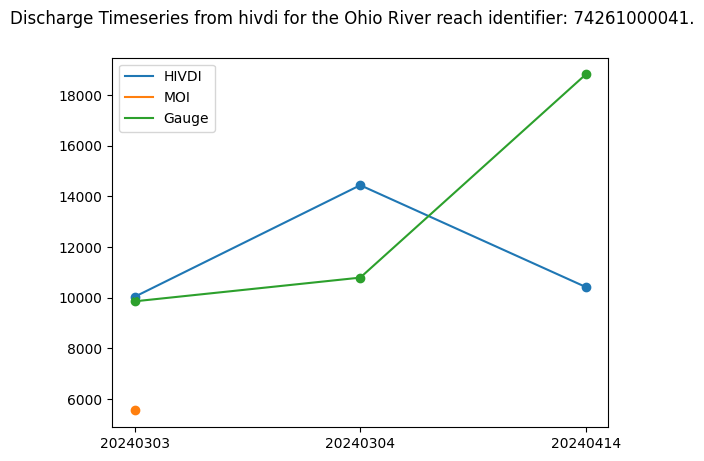

In [9]:
# Plot discharge alongside MOI discharge and gauge discharge

# Discharge algorithm Q
plt.scatter(discharge_time, discharge_algo)
plt.plot(discharge_time, discharge_algo, label=f"{DISCHARGE_ALGORITHM.upper()}")

# MOI Q
plt.scatter(discharge_time, moi_q)
plt.plot(discharge_time, moi_q, label="MOI")

# Gauge Q
plt.scatter(gauge_time, gauge_discharge)
plt.plot(gauge_time, gauge_discharge, label="Gauge")

plt.suptitle(f"Discharge Timeseries from {DISCHARGE_ALGORITHM} for the {RIVER_NAME} reach identifier: {reach_id}.")
plt.legend()
# plt.tight_layout()
